In [21]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import product
from cftime import DatetimeNoLeap
from string import ascii_lowercase, ascii_uppercase

#from dask.distributed import Client, LocalCluster, get_task_stream

#from itertools import product, combinations
#from cftime import DatetimeNoLeap
#from scipy.stats import ks_2samp, epps_singleton_2samp, ttest_ind, wilcoxon, mannwhitneyu
#from collections import ChainMap

In [3]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 22})
xr.set_options(keep_attrs=True,display_style='html')


In [4]:
timescale = 20
DJF_bool = '_DJFonly'
root_path = '/mnt/nas4.meop2/meop40.data.model/CMAM/0A.daily/'
root_path = '/mnt/data04/model/CMAM/0A.daily/'
cesta = f'{root_path}composites_woSSW{DJF_bool}/'

# Functions

In [5]:
def open_date_file(file_path):
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df['BeginDate'] = df.BeginDate.apply(lambda t: pd.to_datetime(t, format='%Y-%m-%d'))
    return df

def tm_mean_xr(x, dims, q = [0.1,0.9]):
    qs = x.quantile(q, dim = dims)
    return x.where((x > qs.sel(quantile = q[0])) & (x < qs.sel(quantile = q[1]))).mean(dims)

# acceldiv

## Open data

In [7]:
sel_var = 'accelogw'
infile = f'{root_path}{sel_var }/{sel_var}_6hrPlev_CMAM_CMAM30-SD_r1i1p1_19790101-20101231_anomalies_zm.nc'
ds = xr.open_dataset(infile)
ds = ds.sortby('time')
ds[sel_var] = ds[sel_var]*24*3600.
ds = ds.resample(time = '1D').mean('time')
ds['time'] = ds.indexes['time'].to_datetimeindex()
ds['plev'] = ds['plev']/100.
ds['plev'].attrs['units'] = 'hPa'
ds

/tmp/ipykernel_2671735/423478415.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = ds.indexes['time'].to_datetimeindex()


<xarray.Dataset>
Dimensions:   (lat: 48, plev: 63, time: 11680)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2010-12-31
  * plev      (plev) float64 1e+03 925.0 850.0 800.0 ... 0.0015 0.001 0.0007
  * lat       (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
Data variables:
    accelogw  (time, plev, lat) float64 1.238e-11 1.238e-11 ... 0.0007593

# 20 days

In [25]:
len(hourly_index_temp)

100

In [21]:
hourly_index_temp = [DatetimeNoLeap(*x, hour) for x, hour in product(zip(dates.year, dates.month, dates.day), range(0,24,6))]

In [27]:
ds.sel(time = hourly_index_temp, plev = [70], lat = slice(20,40))

<xarray.Dataset>
Dimensions:   (lat: 6, plev: 1, time: 100)
Coordinates:
  * plev      (plev) float64 70.0
  * lat       (lat) float64 20.41 24.12 27.83 31.54 35.26 38.97
  * time      (time) object 1980-01-23 00:00:00 ... 2010-12-30 18:00:00
    month     (time) int64 1 1 1 1 2 2 2 2 2 2 2 ... 12 12 2 2 2 2 12 12 12 12
Data variables:
    accelogw  (time, plev, lat) float64 -0.08245 -0.2654 ... -1.057 0.3821

In [23]:
ds.sel(time = dates, plev = [70], lat = slice(20,40))

<xarray.Dataset>
Dimensions:   (lat: 6, plev: 1, time: 25)
Coordinates:
  * plev      (plev) float64 70.0
  * lat       (lat) float64 20.41 24.12 27.83 31.54 35.26 38.97
  * time      (time) datetime64[ns] 1980-01-23 1980-02-25 ... 2010-12-30
    month     (time) int64 1 2 2 1 2 12 1 1 1 12 1 ... 1 2 12 1 1 12 2 1 12 2 12
Data variables:
    accelogw  (time, plev, lat) float64 -0.08245 -0.2654 ... -1.239 -0.2151

In [8]:
name_ls = ['himalayas','eastasia','westamer']
ds_ls2 = []
max_lag = 10
g_method = 'dayofyear' # 'month'
timescale = 20

for name in name_ls:
    df_dates = open_date_file(f"accelogw_{name}_hotspot@70hPa_{timescale}dayts_indexes.csv")
    
    ds_ls = []
    for il, lag in enumerate(range(-max_lag,max_lag+1)):
        #print(lag)
        dates = df_dates.set_index('BeginDate')

        dates = dates.index + pd.Timedelta(str(lag)+' days')
        #filter lags withi 29th February
        #dates = dates[dates.apply(lambda x: not (x.day in [29] and x.month in [2]))]
        dates = dates[~((dates.month == 2) & (dates.day == 29))]
        #filter dates shited to year out of range
        #dates = dates[dates.apply(lambda x: not (x.year in [1978,2011]))]
        dates =  dates[(dates.year != 2011) & (dates.year != 1978)]
        dates = dates[(dates.month == 12) | (dates.month == 1) | (dates.month == 2)]
        hourly_index_temp = [DatetimeNoLeap(*x, hour) for x, hour in product(zip(dates.year, dates.month, dates.day), range(0,24,6))]
        # plev = [300,200,30,10]
        ds_sel_dates = ds.sel(time = dates, plev = [70], lat = slice(20,40)).mean('lat') # daily
        #ds_sel_dates = ds.sel(time = hourly_index_temp, plev = [70], lat = slice(20,40)) # 6-hourly
        ds_ls.append(ds_sel_dates)
        
    temp = xr.concat(ds_ls, dim = 'lag')
    temp['lag'] = range(-max_lag, max_lag+1)
    ds_ls2.append(temp)
    
ds_all = xr.concat(ds_ls2, dim = 'what')
ds_all['what'] = name_ls
ds_all

<xarray.Dataset>
Dimensions:   (lag: 21, plev: 1, time: 1565, what: 3)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-06 1979-01-07 ... 2010-12-30
  * plev      (plev) float64 70.0
  * lag       (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10
  * what      (what) <U9 'himalayas' 'eastasia' 'westamer'
Data variables:
    accelogw  (what, lag, time, plev) float64 -0.1214 nan nan ... nan -0.6962

In [9]:
df_all = ds_all.to_array().to_dataframe(name = sel_var).reset_index().drop(columns=['time'])#)
df_all.head()

,variable,what,lag,plev,accelogw
0,accelogw,himalayas,-10,70.0,-0.121385
1,accelogw,himalayas,-10,70.0,NaN
2,accelogw,himalayas,-10,70.0,NaN
3,accelogw,himalayas,-10,70.0,NaN
4,accelogw,himalayas,-10,70.0,NaN


## visualization

Text(0.5, 1.0, '')

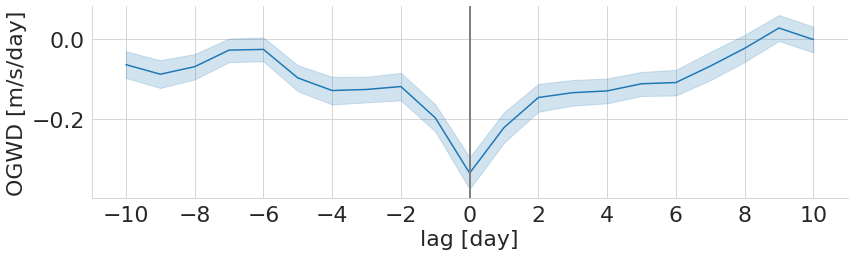

In [30]:
sel_what = 'himalayas'
threshold_dict = dict(aspect_ratio = 2.3, 
                      centroid_latitude = 72,
                      uref_ratio = 0.4,
                      kurtosis = 1.7,
                      objective_area = None)
                      
mask = (df_all['what'] == sel_what) 
data = df_all[mask]#.drop(columns = '')

g = sns.FacetGrid(data, row = 'plev', sharey=True,  height = 4, aspect = 3)#, margin_titles = True)
g.map(sns.lineplot, "lag", sel_var, n_boot=10000)
g.map(plt.axvline, x=0, c='gray', lw = 2)
#g.map(plt.axhline, y=0, c='k', ls = 'dashed')
#g.map(plt.axhline, y=0, c='k')
g.axes[0][0].xaxis.set_major_locator(MultipleLocator(2))
g.axes[0][0].set_ylbabel('OGWD [m/s/day]')
g.axes[-1][0].set_xlabel('lag [day]')
#g.axes[0][0].set_title('Zonally averaged at 70 hPa and 20-40°N')
g.axes[0][0].set_title('')
#plt.savefig(f'OGWD_ZM_composite.pdf', bbox_inches='tight')

# Refractive index

In [10]:
sel_var = 'refr_index'
what = 'anomalies' # 'absolute'#
infile = f'{root_path}{sel_var }/{sel_var}_6hrPlev_CMAM_CMAM30-SD_r1i1p1_19790101-20101231_{what}.nc'
ds = xr.open_dataset(infile)
ds[sel_var] = ds[sel_var]*24*3600.
ds = ds.resample(time = '1D').mean('time')
ds['time'] = ds.indexes['time'].to_datetimeindex()
ds['plev'] = ds['plev']/100.
ds['plev'].attrs['units'] = 'hPa'
ds

/tmp/ipykernel_2671735/3836862584.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = ds.indexes['time'].to_datetimeindex()


<xarray.Dataset>
Dimensions:     (lat: 48, plev: 63, time: 11680, wavenumber: 3)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2010-12-31
  * plev        (plev) float64 1e+03 925.0 850.0 800.0 ... 0.0015 0.001 0.0007
  * lat         (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * wavenumber  (wavenumber) int64 1 2 3
Data variables:
    refr_index  (time, wavenumber, plev, lat) float64 1.6e+08 ... -3.095e+08

In [11]:
name_ls = ['himalayas','eastasia','westamer']
ds_ls2 = []
max_lag = 10
g_method = 'dayofyear' # 'month'

for name in name_ls:
    df_dates = open_date_file(f"accelogw_{name}_hotspot@70hPa_20dayts_indexes.csv")
    
    ds_ls = []
    for il, lag in enumerate(range(-max_lag,max_lag+1)):
        #print(lag)
        dates = df_dates.set_index('BeginDate')

        dates = dates.index + pd.Timedelta(str(lag)+' days')
        #filter lags withi 29th February
        #dates = dates[dates.apply(lambda x: not (x.day in [29] and x.month in [2]))]
        dates = dates[~((dates.month == 2) & (dates.day == 29))]
        #filter dates shited to year out of range
        #dates = dates[dates.apply(lambda x: not (x.year in [1978,2011]))]
        dates =  dates[(dates.year != 2011) & (dates.year != 1978)]
        dates = dates[(dates.month == 12) | (dates.month == 1) | (dates.month == 2)]
        
        # plev = [300,200,30,10]
        hourly_index_temp = [DatetimeNoLeap(*x, hour) for x, hour in product(zip(dates.year, dates.month, dates.day), range(0,24,6))]
        
        ds_sel_dates = ds.sel(time = dates, \
                              plev = slice(200,70), \
                              lat = slice(35,45))#.mean(['lat','plev'])
        """
        ds_sel_dates = ds.sel(time = hourly_index_temp, \
                              plev = slice(200,70), \
                              lat = slice(35,45))#.mean(['lat','plev']) 
        """
        temp = tm_mean_xr(ds_sel_dates, ['lat','plev'])#(trim_mean(ds_sel_dates['refr_index'].stack(points = ('lat','plev')).values, 0.1, axis=2)
        ds_ls.append(temp)#xr.DataArray(temp, dims = ['wavenumber']))
        
    temp = xr.concat(ds_ls, dim = 'lag')
    temp['lag'] = range(-max_lag, max_lag+1)
    ds_ls2.append(temp)
    
ds_all = xr.concat(ds_ls2, dim = 'what')
ds_all['what'] = name_ls
ds_all

<xarray.Dataset>
Dimensions:     (lag: 21, time: 1565, wavenumber: 3, what: 3)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-06 1979-01-07 ... 2010-12-30
  * wavenumber  (wavenumber) int64 1 2 3
  * lag         (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 ... 2 3 4 5 6 7 8 9 10
  * what        (what) <U9 'himalayas' 'eastasia' 'westamer'
Data variables:
    refr_index  (what, lag, time, wavenumber) float64 -2.03e+05 ... -5.521e+05

In [12]:
df_all2 = ds_all.to_array().to_dataframe(name = sel_var).reset_index().drop(columns=['time'])#)
df_all2 = df_all2.rename(columns={'refr_index':'accelogw'})
df_all2.head()

,variable,what,lag,wavenumber,accelogw
0,refr_index,himalayas,-10,1,-202985.081658
1,refr_index,himalayas,-10,2,-202985.081658
2,refr_index,himalayas,-10,3,-202985.081658
3,refr_index,himalayas,-10,1,NaN
4,refr_index,himalayas,-10,2,NaN


Text(0.5, 43.76000000000002, 'lag [day]')

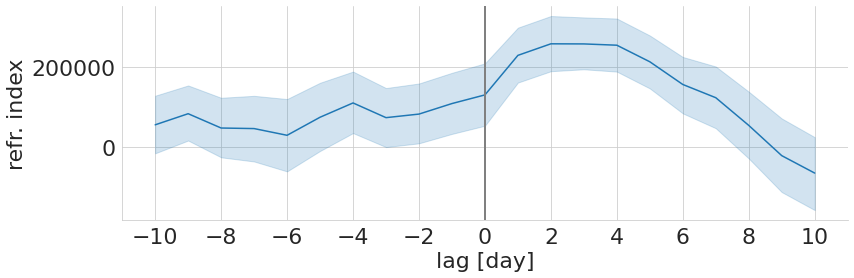

In [43]:
sel_what = 'himalayas'
threshold_dict = dict(aspect_ratio = 2.3, 
                      centroid_latitude = 72,
                      uref_ratio = 0.4,
                      kurtosis = 1.7,
                      objective_area = None)
                      
mask = (df_all2['what'] == sel_what) & (df_all2['wavenumber'] == 1) 
data = df_all2[mask]#.drop(columns = '')

g = sns.FacetGrid(data,  sharey=True,  height = 4, aspect = 3)#, margin_titles = True) row = 'wavenumber',
g.map(sns.lineplot, "lag", 'accelogw', n_boot=10000)
g.map(plt.axvline, x=0, c='gray', lw = 2)
#g.set(yscale='log')
#g.map(plt.axhline, y=0, c='k')
g.axes[0][0].xaxis.set_major_locator(MultipleLocator(2))
g.axes[0][0].set_ylabel('refr. index')
g.axes[0][0].set_xlabel('lag [day]')
#plt.savefig(f'refr_lagA_composite_CI.pdf', bbox_inches='tight')

In [39]:
df_all.shape[0]+df_all2.shape[0]

3549420

In [17]:
sel_what = 'himalayas'
mask = (df_all['what'] == sel_what) 
data = df_all[mask]
mask = (df_all2['what'] == sel_what) & (df_all2['wavenumber'] == 1) 
data2 = df_all2[mask]
df_conc = pd.concat([data2, data])
df_conc.shape

(65730, 6)

In [50]:
g.axes.shape

(2, 1)

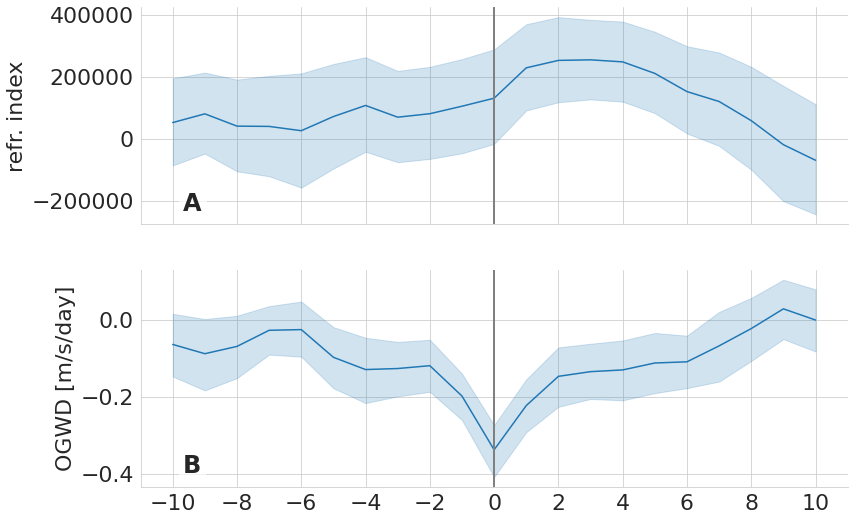

In [23]:
sel_what = 'himalayas'
threshold_dict = dict(aspect_ratio = 2.3, 
                      centroid_latitude = 72,
                      uref_ratio = 0.4,
                      kurtosis = 1.7,
                      objective_area = None)
                      
#.drop(columns = '')

g = sns.FacetGrid(df_conc,  sharey=False,  row = 'variable', height = 4, aspect = 3)#, margin_titles = True) row = 'wavenumber',
g.map(sns.lineplot, "lag", 'accelogw', n_boot=10000)
g.map(plt.axvline, x=0, c='gray', lw = 2)
#g.set(yscale='log')
#g.map(plt.axhline, y=0, c='k')
g.axes[1][0].xaxis.set_major_locator(MultipleLocator(2))
g.axes[1][0].set_ylabel('OGWD [m/s/day]')
g.axes[1][0].set_title('')
g.axes[0][0].set_ylabel('refr. index')
g.axes[0][0].set_xlabel('lag [day]')
g.axes[0][0].set_title('')

for i, ax in enumerate(g.axes.flat): #range(3): 
    ax.text(0.06, 0.15, ascii_uppercase[i], transform=ax.transAxes,
                      fontsize=24, fontweight='bold', va='top', 
            bbox={'alpha': 0.7, 'facecolor': 'white'})
plt.savefig(f'OGWDzm+refr_lagA_composite_CI_daily.pdf', bbox_inches='tight')